<a href="https://colab.research.google.com/github/kky107102/ML_TEAM8/blob/main/ai_vs_real_vgg16_and_resnet18%3Aresnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ai-generated-images-vs-real-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4423404%2F7598969%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240513%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240513T073714Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9fa36a1a3990abfd4f9a942713be9c1b47546e64790ddd9969b4597893532ca7c875f80a5cd673f6e69174861896a098d95b341adead10ba79c0f6db4691f8aa98a12c429803027069c06d370bbd4db4fe02ec0e0508d0fc7fd0756f993efdbcdf4a2fa07753319aeb16f4300a2dff7a5851953521c7d1ed82b269c7c5c14d11cf122a8034bd22c3cff12d5b3fe948e7d46e7dd700817996877b598541ce46be64c6d2034dc792d4d4ce7622acab25ef4b68e59f63569d4167ce5d17f2caf82f3cc0839071343cc3aa61adbffa0461e32a18b2ca6c896f7a2a5562c0e468af3f7faa4864bd62eaee7f7c0236a28d6fd291334cfe642894636e77c19dc6b7a592'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 499048119 bytes downloaded
Downloaded and uncompressed: ai-generated-images-vs-real-images
Data source import complete.


cpu
219 100


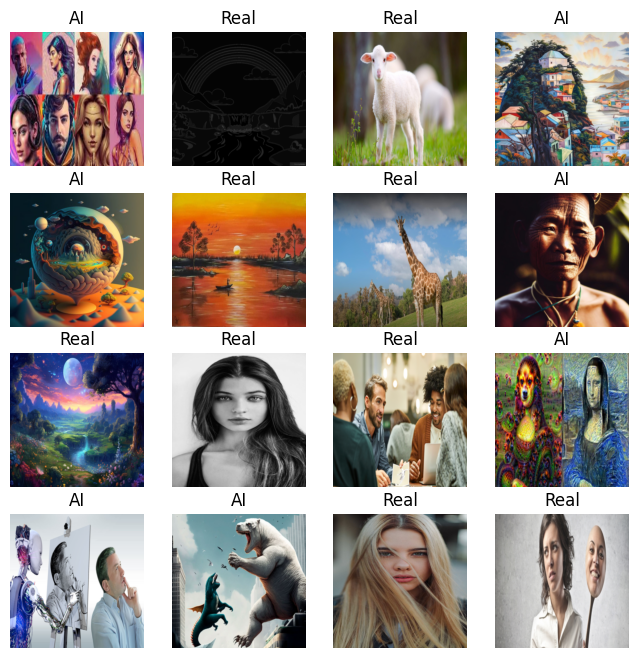

In [ ]:
import numpy as np
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt
import random

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(device)

######################################## dataloader ########################################
class MyDataset(Dataset):
    def __init__(self):
        ai_path = "/kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData/*"
        real_path = "/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/*"
        self.data = []
        for p in glob.glob(real_path):
            self.data.append([p,  0])
        for p in glob.glob(ai_path):
            self.data.append([p, 1])
        random.shuffle(self.data)

    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        image, target = read_image(self.data[index][0]), self.data[index][1]
        t = T.Compose([
            T.Resize((300, 300), antialias=True),
            T.Lambda(lambda x : x.repeat(3,1,1) if x.size(0) == 1 else x),
            T.Lambda(lambda x : x[:3,:, :] if x.size(0) == 4 else x),
            T.ToDtype(torch.float, scale=True),
            T.ToPureTensor()])
        image, target = t(image), target
        return image, target


batch_size = 4
my_dataset = MyDataset()

indices = [i for i in range(len(my_dataset))]
dataset_train = torch.utils.data.Subset(my_dataset, indices[:-100])
dataset_test = torch.utils.data.Subset(my_dataset, indices[-100:])
loader_train = DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=1, shuffle=True)

######################################## dataloader ########################################
print(len(loader_train), len(loader_test))
fig, axs = plt.subplots(4,batch_size, figsize=(8, 8))
row = 0
for images, targets in loader_train:
    for j in range(batch_size):
        axs[row][j].imshow(images[j].permute(1,2,0))
        axs[row][j].set_title("Real" if targets[j] == 0 else "AI")
        axs[row][j].axis("off");
    row += 1
    if row == 4:
        break

In [ ]:
from torch import nn
import torch.nn.functional as F

######################################## My CNN ########################################
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.ada_pool = nn.AdaptiveAvgPool2d((10, 10))
        self.fc1 = nn.LazyLinear(100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.ada_pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

my_net = MyNet()
print(my_net)

MyNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ada_pool): AdaptiveAvgPool2d(output_size=(10, 10))
  (fc1): LazyLinear(in_features=0, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
from torchvision import models

######################################## VGG16 ########################################
def get_my_vgg16():
    my_vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    for params in my_vgg16.parameters():
        params.requires_grad = False
    # print("original vgg16:\n", my_vgg16)


    in_features = my_vgg16.classifier[6].in_features

    my_vgg16.classifier[6] = nn.Sequential(
    nn.Linear(in_features, 100),
    nn.ReLU(),
    nn.Dropout(p = 0.2),
    nn.Linear(100, 2),
    nn.Softmax(dim=1))
    # print("new vgg16:\n", my_vgg16)
    return my_vgg16

def get_my_resnet18():
    my_resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    for params in my_resnet18.parameters():
        params.requires_grad = False

    in_features = my_resnet18.fc.in_features
    my_resnet18.fc = nn.Sequential(
    nn.Linear(in_features, 100),
        nn.ReLU(),
    nn.Dropout(p = 0.2),
    nn.Linear(100, 2),
    nn.Softmax(dim=1))

    return my_resnet18

my_resnet18 = get_my_resnet18()
print(my_resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
######################################## examples of model IO ########################################
# model = MyNet()
# model = get_my_vgg16()
model = get_my_resnet18()
model.to(device)
for images, targets in loader_train:
    images, targets = images.to(device), targets.to(device)
    print(images.size())
    pred = model(images)
    print(pred)
    print(targets)
    break

for images, targets in loader_test:
    images, targets = images.to(device), targets.to(device)
    print(images.size())
    pred = model(images)
    print(pred[0][0].item())
    print(targets[0].item())
    break

torch.Size([4, 3, 300, 300])
tensor([[0.5147, 0.4853],
        [0.4877, 0.5123],
        [0.4665, 0.5335],
        [0.4757, 0.5243]], grad_fn=<SoftmaxBackward0>)
tensor([0, 0, 1, 0])
torch.Size([1, 3, 300, 300])
0.44651859998703003
1


initial evalution:
--------- evalution -------
total number of images in test =  100
loss =  tensor(0.7955)
TP, TN, FP, FN =  2 48 3 47
precision =  0.4
recall =  0.04081632653061224
accurary =  0.5
---------------------------
start training:
----- epoch  0 -------
0.6694846153259277
0.8364604711532593
0.6814205646514893
--------- evalution -------
total number of images in test =  100
loss =  tensor(0.3147)
TP, TN, FP, FN =  48 13 38 1
precision =  0.5581395348837209
recall =  0.9795918367346939
accurary =  0.61
---------------------------
----- epoch  1 -------
0.5714281797409058
0.6504071950912476
0.8120101690292358
--------- evalution -------
total number of images in test =  100
loss =  tensor(0.3179)
TP, TN, FP, FN =  46 21 30 3
precision =  0.6052631578947368
recall =  0.9387755102040817
accurary =  0.67
---------------------------
----- epoch  2 -------
0.5158300995826721
0.5990490913391113
0.35289299488067627
--------- evalution -------
total number of images in test =  100
lo

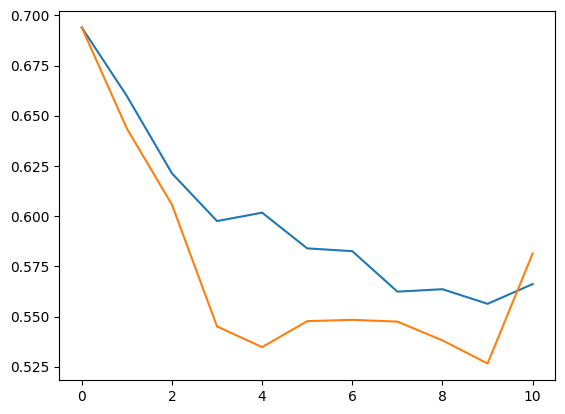

In [10]:
######################################## train and test ########################################

import torch.optim as optim
# model = MyNet()
# model = get_my_vgg16()
model = get_my_resnet18()
model.to(device)
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

def train(model, loss_fn, optimizer):
    i = 0
    total_loss = 0
    model.train()
    for images, targets in loader_train:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        pred = model(images)
        loss = loss_fn(pred, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % 100 == 0:
            print(loss.item())
        i += 1
    return float(total_loss) / float(i)

def test(model, loss_fn):
    i = 0
    total_loss = 0
    TP, TN, FP, FN = 0, 0, 0, 0
    for images, targets in loader_test:
        images, targets = images.to(device), targets.to(device)
        model.eval()
        with torch.no_grad():
            pred = model(images)
            loss = loss_fn(pred, targets)
            total_loss += loss.item()
            #AP: AI is identified as AI
            if targets[0].item() == 1:
                if pred[0][1].item() > 0.5:
                    TP += 1
                else:
                    FN += 1
            else:
                if pred[0][1].item() > 0.5:
                    FP += 1
                else:
                    TN += 1
        i += 1
    total = TP + TN + FP + FN
    print("--------- evalution -------")
    print("total number of images in test = ", total)
    print("loss = ", loss)
    print("TP, TN, FP, FN = ", TP, TN, FP, FN)
    print("precision = ", float(TP) / float(TP + FP))
    print("recall = ", float(TP) / float(TP + FN))
    print("accurary = ", float(TP + TN) / float(total))
    print("---------------------------")
    return float(total_loss) / float(i)

print("initial evalution:")
inital_loss = test(model, loss_fn)
print("start training:")
train_losses = [inital_loss]
test_losses = [inital_loss]
total_epoch = 10
for epoch in range(total_epoch):
    print("----- epoch ", epoch, "-------")
    train_loss = train(model, loss_fn, optimizer)
    test_loss = test(model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

# plotting train loss vs test loss
fig, ax = plt.subplots(1,1)
ax.plot([i for i in range(total_epoch + 1)], train_losses)
ax.plot([i for i in range(total_epoch + 1)], test_losses)

--- printing samples---


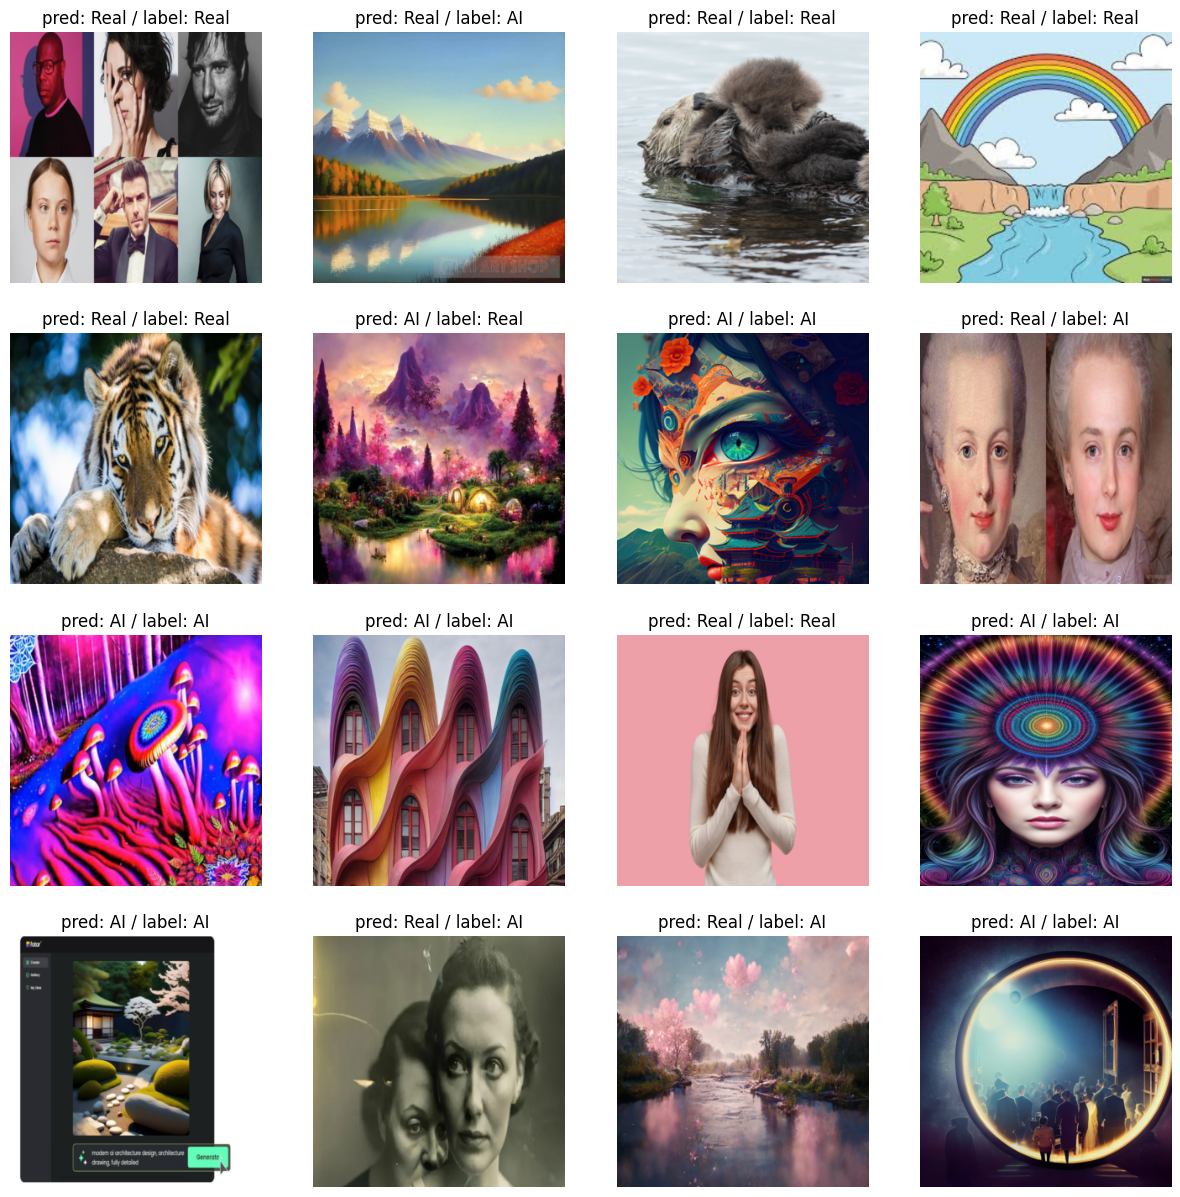

In [11]:
######################################## print examples of classification results ########################################
def print_samples(model):
    print("--- printing samples---")

    fig, axs = plt.subplots(4,4,figsize=(15, 15))
    n = 0
    for images, targets in loader_train:
        images = images.to(device)
        pred = model(images)
        pred = pred.to("cpu")
        images = images.to("cpu")
        if pred[0][0].item() > 0.5:
            title = "pred: Real"
        else:
            title = "pred: AI"

        title += " / label: "
        title += "Real" if targets[0] == 0 else "AI"

        i = n // 4
        j = n % 4
        axs[i][j].imshow(images[0].permute(1,2,0))
        axs[i][j].set_title(title)
        axs[i][j].axis("off");

        n += 1
        if n == 16:
            break
print_samples(model)